In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, dataloader
import torch.nn.functional as F
from torchsummary import summary

import sys
sys.path.append('../src')
from model import UMI

c:\Users\matti\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data generation

In [3]:
def data_gen(n_cat,n_p):
    """Generate clusters of points around uniformly spaced points around origin in 2D

    Arguments:
        n_cat -- Number of categories
        n_p -- Number of points PER CATEGORY

    Returns:
        Array of cluster centers, array of all 2D datapoints, array of all corresponding labels to datapoints
    """
    n_tot = n_cat*n_p # Total number of datapoints
    centers = np.array([[np.cos(t*2*np.pi/n_cat),np.sin(t*2*np.pi/n_cat)] for t in range(n_cat)]) # Generate centers uniformly around the origin
    data = np.zeros((n_tot,2))
    labels = np.zeros(n_tot)
    for i in range(n_cat):
        scatter = np.random.normal(loc=centers[i],scale=.1, size=(n_p,2))
        data[i*n_p:(i+1)*n_p] = scatter
        labels[i*n_p:(i+1)*n_p] = i
    return centers,data,labels
    
n_categories = 4
n_p = 128 # points_per_category
centers,data,labels = data_gen(n_categories,n_p)

### Plotting of data

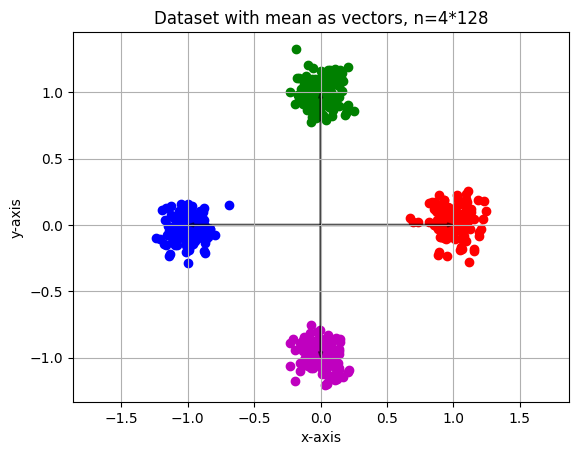

In [4]:
color_atlas = ["r","g","b","m","c","y","orange","brown","lime"]
colors = []
for i in range(n_categories):
    colors.append(color_atlas[i])

for col,center,i in zip(colors,centers,range(n_categories)):
    plt.scatter(data[i*n_p:(i+1)*n_p,0],data[i*n_p:(i+1)*n_p,1],color=col)
    plt.arrow(0,0,center[0],center[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))

plt.title(f"Dataset with mean as vectors, n={n_categories}*{n_p}")
plt.axis("equal")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.grid("on")

### Putting data in PyTorch dataset

In [5]:
class ScatterData(Dataset):
    def __init__(self,points,labels,n_cat):
        self.x = torch.tensor(points).float()
        self.y = torch.tensor(labels).to(int)
        self.y = F.one_hot(self.y, num_classes=n_cat).double()
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [6]:
BATCH_SIZE = 32

training_data = ScatterData(data,labels,n_categories)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

### Create model

In [41]:
model = UMI(2,n_categories,L2=True)

In [42]:
model(torch.tensor([1.,0.]))

tensor([0.4085, 0.1220, 0.1742, 0.2952], grad_fn=<SoftmaxBackward0>)

In [43]:
summary(model,input_size=(1,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]               8
Total params: 8
Trainable params: 8
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Training

In [44]:
w_his = []

In [45]:
def train(loader,model,n_epochs=5):
    losses = []
    epochs = []
    N = len(loader)
    for epoch in tqdm(range(n_epochs)):
        for param in model.parameters():
            w = param
            w_np = w.detach().numpy().copy()
            w_his.append(w_np)
        for i, (inputs,labels) in tqdm(enumerate(loader)):
            loss = model.train_step(inputs,labels)
            losses.append(loss)
            epochs.append(epoch+i/N)
    return np.array(epochs), np.array(losses)

In [46]:
epoch_data, loss_data = train(training_loader,model,n_epochs=500)

16it [00:00, 1453.58it/s]0:00<?, ?it/s]
16it [00:00, 1440.57it/s]
16it [00:00, 2000.38it/s]
16it [00:00, 1567.85it/s]
16it [00:00, 1778.00it/s]
16it [00:00, 1600.76it/s]
16it [00:00, 1454.12it/s]
16it [00:00, 1777.67it/s]
16it [00:00, 1778.61it/s]0:00<00:06, 77.82it/s]
16it [00:00, 1332.48it/s]
16it [00:00, 1599.01it/s]
16it [00:00, 1600.00it/s]
16it [00:00, 1600.00it/s]
16it [00:00, 1777.77it/s]
16it [00:00, 1454.52it/s]
16it [00:00, 1599.20it/s]
16it [00:00, 1681.42it/s]00:00<00:06, 74.87it/s]
16it [00:00, 1777.67it/s]
16it [00:00, 1421.56it/s]
16it [00:00, 1365.53it/s]
16it [00:00, 1540.89it/s]
16it [00:00, 1450.19it/s]
16it [00:00, 1598.32it/s]
16it [00:00, 1181.10it/s]
16it [00:00, 1454.49it/s]00:00<00:06, 72.58it/s]
16it [00:00, 1454.37it/s]
16it [00:00, 1600.00it/s]
16it [00:00, 1599.93it/s]
16it [00:00, 1231.06it/s]
16it [00:00, 1599.16it/s]
16it [00:00, 1683.15it/s]
16it [00:00, 1211.81it/s]
16it [00:00, 1599.39it/s]00:00<00:06, 70.93it/s]
16it [00:00, 1454.52it/s]
16it [00:00

### Training results visualization

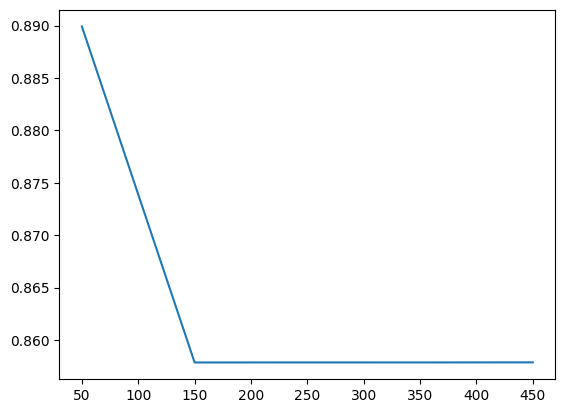

In [47]:
epoch_data_avgd = epoch_data.reshape(5,-1).mean(axis=1)
loss_data_avgd = loss_data.reshape(5,-1).mean(axis=1)
plt.plot(epoch_data_avgd,loss_data_avgd)

### Testing

In [48]:
t_centers, test_data, test_labels = data_gen(n_categories,512)
test_set = ScatterData(test_data,test_labels,n_categories)

acc_tot = 0
for xs, ys in test_set:
    yhat = model(xs).argmax()
    ys = ys.argmax()
    if yhat == ys:
        acc_tot += 1

print(f'Accuracy: {acc_tot/len(test_set):.2f}')

Accuracy: 1.00


### Weights

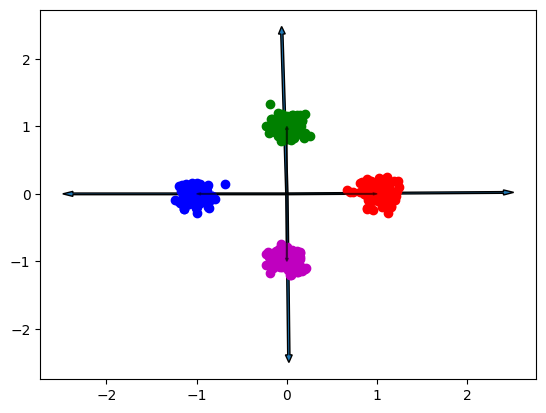

In [49]:


for param in model.parameters():
    w = param

w_np = w.detach().numpy()

for w in w_np:
    w_len = np.linalg.norm(w)
    width = 0.01*w_len
    plt.arrow(0,0,w[0],w[1],length_includes_head=True,width=width)

for col,center,i in zip(colors,centers,range(n_categories)):
    plt.scatter(data[i*n_p:(i+1)*n_p,0],data[i*n_p:(i+1)*n_p,1],color=col)
    plt.arrow(0,0,center[0],center[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))

In [50]:
w_his

[array([[ 0.6092778 ,  0.30816633],
        [-0.59896725,  0.02963489],
        [-0.24293098,  0.39912587],
        [ 0.28438795, -0.54696834]], dtype=float32),
 array([[ 0.76834834,  0.25305018],
        [-0.44676724,  0.18781807],
        [-0.39994797,  0.27943856],
        [ 0.1293257 , -0.70399034]], dtype=float32),
 array([[ 0.9247732 ,  0.18029772],
        [-0.3126041 ,  0.34487876],
        [-0.555795  ,  0.16565478],
        [ 0.01250446, -0.8588045 ]], dtype=float32),
 array([[ 1.0712272 ,  0.10822873],
        [-0.19882946,  0.50009733],
        [-0.7089453 ,  0.07483903],
        [-0.03560941, -1.012922  ]], dtype=float32),
 array([[ 1.2144881 ,  0.03001996],
        [-0.11487766,  0.6523665 ],
        [-0.8588076 , -0.00854285],
        [-0.03302086, -1.1601713 ]], dtype=float32),
 array([[ 1.3522397 , -0.01999218],
        [-0.05146466,  0.7953585 ],
        [-1.0046688 , -0.05932308],
        [ 0.0029018 , -1.3028897 ]], dtype=float32),
 array([[ 1.4800235 , -0.0770838 ]